## Likelihood Estimation

Estimagic has a special interface to estimate model parameters via maximum likelihood. We take a look at the same ordered logit model from the more general [optimization tutorial](ordered_logit_example.ipynb).

``` python
data = pd.read_pickle("ologit.pickle")
formula = 'apply ~ pared + public + gpa'
estimates = ordered_logit(formula, data)

```
The example is taken from the [Stata Documentation](https://stats.idre.ucla.edu/stata/dae/ordered-logistic-regression/). The correct parameters for this model are ``[1.047664, -.0586828, .6157458, 2.203323,  4.298767]``

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from patsy import dmatrices
from estimagic.estimation.estimate import estimate_likelihood

### Process the user input

You can find more information [here](ordered_logit_example.ipynb#Process-the-user-input).

In [2]:
def ordered_logit_processing(formula, data):
    """Process user input for an ordered logit model."""
    # extract data arrays
    y, x = dmatrices(formula + ' - 1', data, return_type='dataframe')
    y = y[y.columns[0]]
    
    # extract dimensions
    num_choices = len(y.unique())
    beta_names = list(x.columns)
    num_betas = len(beta_names)
    num_cutoffs = num_choices - 1
    
    # set-up index for params_df
    names = beta_names + list(range(num_cutoffs))
    categories = ['beta'] * num_betas + ['cutoff'] * num_cutoffs
    index = pd.MultiIndex.from_tuples(
        zip(categories, names), names=['type', 'name'])
    
    # make params_df
    np.random.seed(5471)
    start_params = pd.DataFrame(index=index)
    start_params['value'] = np.hstack(
        [np.random.uniform(low=-0.5, high=0.5, size=len(x.columns)),
        np.arange(num_cutoffs) * 2])
    
    # make constraints
    constr = [{'loc': 'cutoff', 'type': 'increasing'}]
    
    return start_params, y.to_numpy().astype(int), x.to_numpy(), constr

### Calculate the Likelihood

Next we have to evaluate the likelihood function, given parameters and data. There are more efficient ways of calculating the likelihood for an ordered logit, but this one was chosen for brevity and readability.

In most optimization problem, the criterion function returns a scalar. To use the estimagic's likelihood estimation interface, the criterion function needs to return the log likelihood contributions of observations. This has two advantages:

1. The log likelihood contributions are necessary to compute the Jacobians or Hessians for standard error calculations. Estimagic will aggregate the contributions depending on the calculation and the user only needs to specify one criterion function for all purposes.
2. It is generally encouraged to compute the log likelihood because of its numerical properties. It makes it easier to avoid [under- and overflows](https://stackoverflow.com/a/6360102/7523785). See also the [logsumexp trick](https://statmodeling.stat.columbia.edu/2016/06/11/log-sum-of-exponentials/).

In [3]:
def ordered_logit_loglike(params, y, x):
    """Likelihood function of an orderd logit model."""
    # parse the parameter vector into its quantities
    beta = params.loc["beta", "value"].to_numpy()
    cutoffs = params.loc["cutoff", "value"].to_numpy()
    
    # calculate deterministic part of utilities
    xb = x.dot(beta)
    
    # evaluate likelihood
    upper_cutoffs = np.hstack([cutoffs, np.inf])[y]
    lower_cutoffs = np.hstack([-np.inf, cutoffs])[y]
    upper_cdf = stats.logistic.cdf(upper_cutoffs - xb)
    lower_cdf = stats.logistic.cdf(lower_cutoffs - xb)
    
    return np.log(upper_cdf - lower_cdf)

### The ordered_logit command

The estimation command follows the same patter as the ``maximize`` or ``minimize``. Thus, nothing has to be changed except for the criterion function to adopt the other interface.

In [4]:
def ordered_logit(formula, data, dashboard=False):
    """Estimate an ordered probit model with maximum likelihood.
    
    Args:
        formula (str): A patsy formula
        data (str): A pandas DataFrame
        dashboard (bool): Switch on the dashboard.
        
    Returns:
        res: optimization result.
        
    """
    params, y, x, constr = ordered_logit_processing(formula, data)
    
    res = estimate_likelihood(
        criterion=ordered_logit_loglike, 
        params=params, 
        algorithm='scipy_L-BFGS-B',
        constraints=constr,
        criterion_kwargs={"y": y, "x": x}, 
        dashboard=dashboard)
    return res

Note that estimagic has a `maximize` function, so you don't have to switch the sign of your objective function to do a maximization!

### Use the command

In [5]:
df = pd.read_pickle("ologit.pickle")
form = "apply ~ pared + public + gpa"

In [6]:
info, params = ordered_logit(form, df, dashboard=False)

In [7]:
params["correct"] = [1.047664, -.0586828, .6157458, 2.203323,  4.298767]
params[["value", "correct"]]

value   correct
type   name                      
beta   pared   1.047663  1.047664
       public -0.058698 -0.058683
       gpa     0.615885  0.615746
cutoff 0       2.203830  2.203323
       1       4.299397  4.298767

### Visualizing the optimization

Estimagic does not only log parameters and criterion values in the database, but also the contributions by default. Here we are showing the contributions from the first and last evaluation to show their development. Unfortunately, this step is a little bit inconvenient for now, but will become a part of the dashboard soon.

Without much explanation, here are the likelihood contributions of ten individuals over the course of the optimization.

In [8]:
%matplotlib inline

import io
import pickle
import matplotlib.pyplot as plt

from estimagic.logging.create_database import load_database
from estimagic.logging.read_database import read_last_iterations

In [9]:
database = load_database("logging.db")
db_dump = read_last_iterations(database, ["comparison_plot"], 10, "list")
log_contributions = np.column_stack([pickle.load(io.BytesIO(i[0])) for i in db_dump[1:]])

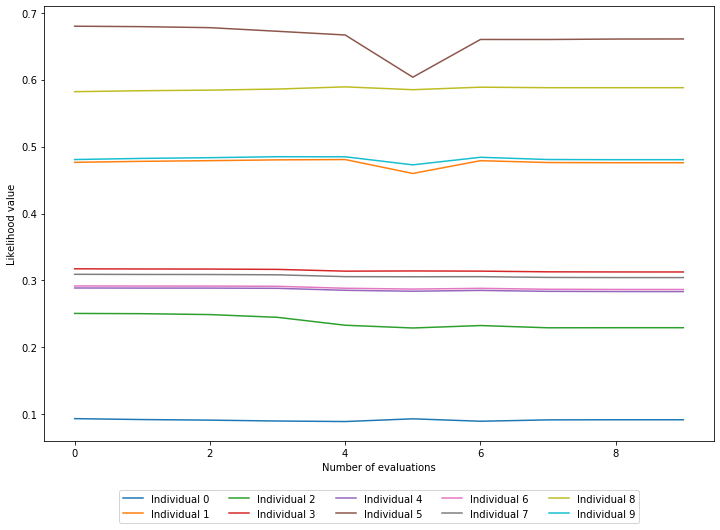

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

for i in range(10):
    ax.plot(np.exp(log_contributions[i]), label=f"Individual {i}")

ax.set_xlabel("Number of evaluations")
ax.set_ylabel("Likelihood value")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10), ncol=5)

plt.show()
plt.close()